In [1]:
import numpy as np
import pandas as pd
from keras.models import load_model
from tensorflow.keras.datasets import mnist

import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf



import matplotlib.pyplot as plt
from scipy import ndimage
from IPython.display import Image

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.applications import xception



#https://keras.io/examples/vision/integrated_gradients/#lets-testdrive-it


In [2]:
# Cargamos el modelo guardado.
cnn_minst = load_model('../1.0 MNIST (keras) - Modelo/trained_model/')
cnn_minst.load_weights('../1.0 MNIST (keras) - Modelo/cnn_weights.h5')

# Comprobamos que se ha cargado bien visualizando la secuencia de capas.
# Size of the input image
img_size = (28, 28, 3)

cnn_minst.summary()

Model: "keras_neuronal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  896       
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  692352    
                                                                 
 dense_1 (Dense)             multiple                  1290      
                                                                 
Total params: 694,538
Trainable params: 694,538
Non-trainable params: 0
______________________________________________

In [3]:
# Cargamos los datos de entrenamiento y prueba en sendos arrays.
(X_train, y_train), (X_test, y_test) = mnist.load_data()
#X_train_scaled = X_train / 255.0
#X_test_scaled = X_test / 255.0

X_train = X_train.reshape((-1,28,28,1)) / 255.0 
X_test = X_test.reshape((-1,28,28,1)) / 255.0 



#X_train_scaled = X_train_scaled.reshape((-1,28,28,1)) / 255.0 
#X_test_scaled = X_test_scaled.reshape((-1,28,28,1)) / 255.0 


11490434/11490434 [==============================] - 5s 0us/step


Transformamos nuestra funcion a 3 canales

In [4]:
# Creamos la función de conversión al tipo RGB.
import numpy as np
def to_rgb(x):
    x_rgb = np.zeros((x.shape[0], 28, 28, 3))
    for i in range(3):
        x_rgb[..., i] = x[..., 0]
    return x_rgb

# La aplicamos a los dos data sets.
X_train = to_rgb(X_train)
X_test = to_rgb(X_test)

In [5]:
print(X_train.shape, X_test.shape)

(60000, 28, 28, 3) (10000, 28, 28, 3)


Primero estableceremos una imagen inicial para calcular la importancia de de las caracteristicas. Intuitivamente se puede pensar como principal explicacion la represntacion del impacto de la ausencia de cada pixel en una imgen predicha para contrastarla con su impacto en cada pixel de la prediccion cunaod es repsentada como input. Como resultado la eleccion del baseline juega un rol principal en la interpretacion y visualizacion de las caracteristicas y la importancia de los pixeles. 

Como el tamaño de nuestra imagen ya esta predefinido 28x28 creamos una imagen en negro, tambien se pueden seleccionar distintos baselines en otros colores. 

In [6]:
baseline = tf.zeros(shape=(28,28,3))

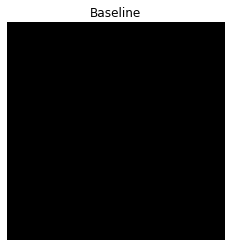

In [7]:
plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()

In [8]:
def get_img_array(img_path, size=(28, 28)):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def get_gradients(img_input, top_pred_idx):
    """Computes the gradients of outputs w.r.t input image.

    Args:
        img_input: 4D image tensor
        top_pred_idx: Predicted label for the input image

    Returns:
        Gradients of the predictions w.r.t img_input
    """
    images = tf.cast(img_input, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = cnn_minst(images)
        top_class = preds[:, top_pred_idx]

    grads = tape.gradient(top_class, images)
    return grads


def get_integrated_gradients(img_input, top_pred_idx, baseline=None, num_steps=50):
    """Computes Integrated Gradients for a predicted label.

    Args:
        img_input (ndarray): Original image
        top_pred_idx: Predicted label for the input image
        baseline (ndarray): The baseline image to start with for interpolation
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.

    Returns:
        Integrated gradients w.r.t input image
    """
    # If baseline is not provided, start with a black image
    # having same size as the input image.
    if baseline is None:
        baseline = np.zeros(img_size).astype(np.float32)
    else:
        baseline = baseline.astype(np.float32)

    # 1. Do interpolation.
    img_input = img_input.astype(np.float32)
    interpolated_image = [
        baseline + (step / num_steps) * (img_input - baseline)
        for step in range(num_steps + 1)
    ]
    interpolated_image = np.array(interpolated_image).astype(np.float32)

    # 2. Preprocess the interpolated images
    interpolated_image = xception.preprocess_input(interpolated_image)

    # 3. Get the gradients
    grads = []
    for i, img in enumerate(interpolated_image):
        img = tf.expand_dims(img, axis=0)
        grad = get_gradients(img, top_pred_idx=top_pred_idx)
        grads.append(grad[0])
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)

    # 4. Approximate the integral using the trapezoidal rule
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)

    # 5. Calculate integrated gradients and return
    integrated_grads = (img_input - baseline) * avg_grads
    return integrated_grads


def random_baseline_integrated_gradients(
    img_input, top_pred_idx, num_steps=50, num_runs=2):
    """Generates a number of random baseline images.
    
    Args:
        img_input (ndarray): 3D image
        top_pred_idx: Predicted label for the input image
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.
        num_runs: number of baseline images to generate

    Returns:
        Averaged integrated gradients for `num_runs` baseline images
    """
    # 1. List to keep track of Integrated Gradients (IG) for all the images
    img_size = img_input.shape[1:]  # Obtener las dimensiones de la imagen de entrada
    integrated_grads = []

    # 2. Get the integrated gradients for all the baselines
    for run in range(num_runs):
        baseline = np.random.random(img_size) * 255
        igrads = get_integrated_gradients(
            img_input=img_input,
            top_pred_idx=top_pred_idx,
            baseline=baseline,
            num_steps=num_steps,
        )
        integrated_grads.append(igrads)

    # 3. Return the average integrated gradients for the image
    integrated_grads = tf.convert_to_tensor(integrated_grads)
    return tf.reduce_mean(integrated_grads, axis=0)

In [9]:
class GradVisualizer:
    """Plot gradients of the outputs w.r.t an input image."""

    def __init__(self, positive_channel=None, negative_channel=None):
        if positive_channel is None:
            self.positive_channel = [0, 255, 0]
        else:
            self.positive_channel = positive_channel

        if negative_channel is None:
            self.negative_channel = [255, 0, 0]
        else:
            self.negative_channel = negative_channel

    def apply_polarity(self, attributions, polarity):
        if polarity == "positive":
            return np.clip(attributions, 0, 1)
        else:
            return np.clip(attributions, -1, 0)

    def apply_linear_transformation(
        self,
        attributions,
        clip_above_percentile=99.9,
        clip_below_percentile=70.0,
        lower_end=0.2,
    ):
        # 1. Get the thresholds
        m = self.get_thresholded_attributions(
            attributions, percentage=100 - clip_above_percentile
        )
        e = self.get_thresholded_attributions(
            attributions, percentage=100 - clip_below_percentile
        )

        # 2. Transform the attributions by a linear function f(x) = a*x + b such that
        # f(m) = 1.0 and f(e) = lower_end
        transformed_attributions = (1 - lower_end) * (np.abs(attributions) - e) / (
            m - e
        ) + lower_end

        # 3. Make sure that the sign of transformed attributions is the same as original attributions
        transformed_attributions *= np.sign(attributions)

        # 4. Only keep values that are bigger than the lower_end
        transformed_attributions *= transformed_attributions >= lower_end

        # 5. Clip values and return
        transformed_attributions = np.clip(transformed_attributions, 0.0, 1.0)
        return transformed_attributions

    def get_thresholded_attributions(self, attributions, percentage):
        if percentage == 100.0:
            return np.min(attributions)

        # 1. Flatten the attributions
        flatten_attr = attributions.flatten()

        # 2. Get the sum of the attributions
        total = np.sum(flatten_attr)

        # 3. Sort the attributions from largest to smallest.
        sorted_attributions = np.sort(np.abs(flatten_attr))[::-1]

        # 4. Calculate the percentage of the total sum that each attribution
        # and the values about it contribute.
        cum_sum = 100.0 * np.cumsum(sorted_attributions) / total

        # 5. Threshold the attributions by the percentage
        indices_to_consider = np.where(cum_sum >= percentage)[0][0]

        # 6. Select the desired attributions and return
        attributions = sorted_attributions[indices_to_consider]
        return attributions

    def binarize(self, attributions, threshold=0.001):
        return attributions > threshold

    def morphological_cleanup_fn(self, attributions, structure=np.ones((4, 4))):
        closed = ndimage.grey_closing(attributions, structure=structure)
        opened = ndimage.grey_opening(closed, structure=structure)
        return opened

    def draw_outlines(
        self, attributions, percentage=90, connected_component_structure=np.ones((3, 3))
    ):
        # 1. Binarize the attributions.
        attributions = self.binarize(attributions)

        # 2. Fill the gaps
        attributions = ndimage.binary_fill_holes(attributions)

        # 3. Compute connected components
        connected_components, num_comp = ndimage.measurements.label(
            attributions, structure=connected_component_structure
        )

        # 4. Sum up the attributions for each component
        total = np.sum(attributions[connected_components > 0])
        component_sums = []
        for comp in range(1, num_comp + 1):
            mask = connected_components == comp
            component_sum = np.sum(attributions[mask])
            component_sums.append((component_sum, mask))

        # 5. Compute the percentage of top components to keep
        sorted_sums_and_masks = sorted(component_sums, key=lambda x: x[0], reverse=True)
        sorted_sums = list(zip(*sorted_sums_and_masks))[0]
        cumulative_sorted_sums = np.cumsum(sorted_sums)
        cutoff_threshold = percentage * total / 100
        cutoff_idx = np.where(cumulative_sorted_sums >= cutoff_threshold)[0][0]
        if cutoff_idx > 2:
            cutoff_idx = 2

        # 6. Set the values for the kept components
        border_mask = np.zeros_like(attributions)
        for i in range(cutoff_idx + 1):
            border_mask[sorted_sums_and_masks[i][1]] = 1

        # 7. Make the mask hollow and show only the border
        eroded_mask = ndimage.binary_erosion(border_mask, iterations=1)
        border_mask[eroded_mask] = 0

        # 8. Return the outlined mask
        return border_mask

    def process_grads(
        self,
        image,
        attributions,
        polarity="positive",
        clip_above_percentile=99.9,
        clip_below_percentile=0,
        morphological_cleanup=False,
        structure=np.ones((3, 3)),
        outlines=False,
        outlines_component_percentage=90,
        overlay=True,
    ):
        if polarity not in ["positive", "negative"]:
            raise ValueError(
                f""" Allowed polarity values: 'positive' or 'negative'
                                    but provided {polarity}"""
            )
        if clip_above_percentile < 0 or clip_above_percentile > 100:
            raise ValueError("clip_above_percentile must be in [0, 100]")

        if clip_below_percentile < 0 or clip_below_percentile > 100:
            raise ValueError("clip_below_percentile must be in [0, 100]")

        # 1. Apply polarity
        if polarity == "positive":
            attributions = self.apply_polarity(attributions, polarity=polarity)
            channel = self.positive_channel
        else:
            attributions = self.apply_polarity(attributions, polarity=polarity)
            attributions = np.abs(attributions)
            channel = self.negative_channel

        # 2. Take average over the channels
        attributions = np.average(attributions, axis=2)

        # 3. Apply linear transformation to the attributions
        attributions = self.apply_linear_transformation(
            attributions,
            clip_above_percentile=clip_above_percentile,
            clip_below_percentile=clip_below_percentile,
            lower_end=0.0,
        )

        # 4. Cleanup
        if morphological_cleanup:
            attributions = self.morphological_cleanup_fn(
                attributions, structure=structure
            )
        # 5. Draw the outlines
        if outlines:
            attributions = self.draw_outlines(
                attributions, percentage=outlines_component_percentage
            )

        # 6. Expand the channel axis and convert to RGB
        attributions = np.expand_dims(attributions, 2) * channel

        # 7.Superimpose on the original image
        if overlay:
            attributions = np.clip((attributions * 0.8 + image), 0, 255)
        return attributions

    def visualize(
        self,
        image,
        gradients,
        integrated_gradients,
        polarity="positive",
        clip_above_percentile=99.9,
        clip_below_percentile=0,
        morphological_cleanup=False,
        structure=np.ones((3, 3)),
        outlines=False,
        outlines_component_percentage=90,
        overlay=True,
        figsize=(15, 8),
    ):
        # 1. Make two copies of the original image
        img1 = np.copy(image)
        img2 = np.copy(image)

        # 2. Process the normal gradients
        grads_attr = self.process_grads(
            image=img1,
            attributions=gradients,
            polarity=polarity,
            clip_above_percentile=clip_above_percentile,
            clip_below_percentile=clip_below_percentile,
            morphological_cleanup=morphological_cleanup,
            structure=structure,
            outlines=outlines,
            outlines_component_percentage=outlines_component_percentage,
            overlay=overlay,
        )

        # 3. Process the integrated gradients
        igrads_attr = self.process_grads(
            image=img2,
            attributions=integrated_gradients,
            polarity=polarity,
            clip_above_percentile=clip_above_percentile,
            clip_below_percentile=clip_below_percentile,
            morphological_cleanup=morphological_cleanup,
            structure=structure,
            outlines=outlines,
            outlines_component_percentage=outlines_component_percentage,
            overlay=overlay,
        )

        _, ax = plt.subplots(1, 3, figsize=figsize)
        ax[0].imshow(image)
        ax[1].imshow(grads_attr.astype(np.uint8))
        ax[2].imshow(igrads_attr.astype(np.uint8))

        ax[0].set_title("Input")
        ax[1].set_title("Normal gradients")
        ax[2].set_title("Integrated gradients")
        plt.show()

In [10]:
#orig_img

X_train[5]
print(type(X_train[100]))

<class 'numpy.ndarray'>


##### Obersacion 1 y 2

Eleccion de dos imagenes aleatorias para su estudio mediante Integrated Gradients

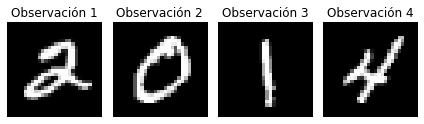

In [11]:
# Crea una figura y subplots
fig, axs = plt.subplots(1, 4)

l_images = [X_train[5], X_train[1], X_train[8], X_train[9]]
i=1
for image in l_images:
    # Configura el primer subplot
    title = f"Observación {i}"
    axs[i-1].imshow(image)
    axs[i-1].set_title(label=title)
    axs[i-1].axis('off')
    
    i += 1
# Ajusta los márgenes entre los subplots
plt.tight_layout()

# Muestra la figura con los subplots
plt.show()

In [12]:
l_images = [X_train[5], X_train[1], X_train[8], X_train[9]]

image = tf.expand_dims(X_train[5], axis=0)
image = tf.cast(image, dtype=tf.float32)

image_2 = tf.expand_dims(X_train[1], axis=0)
image_2 = tf.cast(image_2, dtype=tf.float32)

image_3 = tf.expand_dims(X_train[8], axis=0)
image_3 = tf.cast(image_3, dtype=tf.float32)

image_4 = tf.expand_dims(X_train[9], axis=0)
image_4 = tf.cast(image_4, dtype=tf.float32)
# 2. Keep a copy of the original image


##### Forward pass de la imagen seleccionada 

In [13]:
# Realizacion del forward pass 1
preds = cnn_minst.predict(image)
top_pred_idx = tf.argmax(preds[0])
print("Predicted class index:", top_pred_idx)

# Realizacion del forward pass 2
preds_2 = cnn_minst.predict(image_2)
top_pred_idx_2 = tf.argmax(preds_2[0])
print("Predicted class index:", top_pred_idx_2)

# Realizacion del forward pass 3
preds_3 = cnn_minst.predict(image_3)
top_pred_idx_3 = tf.argmax(preds_3[0])
print("Predicted class index:", top_pred_idx_3)

# Realizacion del forward pass 
preds_4 = cnn_minst.predict(image_4)
top_pred_idx_4 = tf.argmax(preds_4[0])
print("Predicted class index:", top_pred_idx_4)



1/1 [==============================] - 0s 118ms/step
Predicted class index: tf.Tensor(2, shape=(), dtype=int64)
1/1 [==============================] - 0s 15ms/step
Predicted class index: tf.Tensor(0, shape=(), dtype=int64)
1/1 [==============================] - 0s 16ms/step
Predicted class index: tf.Tensor(1, shape=(), dtype=int64)
1/1 [==============================] - 0s 15ms/step
Predicted class index: tf.Tensor(4, shape=(), dtype=int64)


In [14]:
#image_1 = tf.expand_dims(X_train_scaled[0], axis=0)
#image_1 = tf.cast(image_1, dtype=tf.float32)
#image_1.shape

In [14]:
# 5. Get the gradients of the last layer for the predicted label
grads = get_gradients(image, top_pred_idx=top_pred_idx)
orig_img=X_train[5]


# 5. Get the gradients of the last layer for the predicted label
grads_2 = get_gradients(image_2, top_pred_idx=top_pred_idx_2)
orig_img_2=X_train[1]

# 5. Get the gradients of the last layer for the predicted label
grads_3 = get_gradients(image_3, top_pred_idx=top_pred_idx_3)
orig_img_3=X_train[8]

# 5. Get the gradients of the last layer for the predicted label
grads_4 = get_gradients(image_4, top_pred_idx=top_pred_idx_4)
orig_img_4=X_train[9]

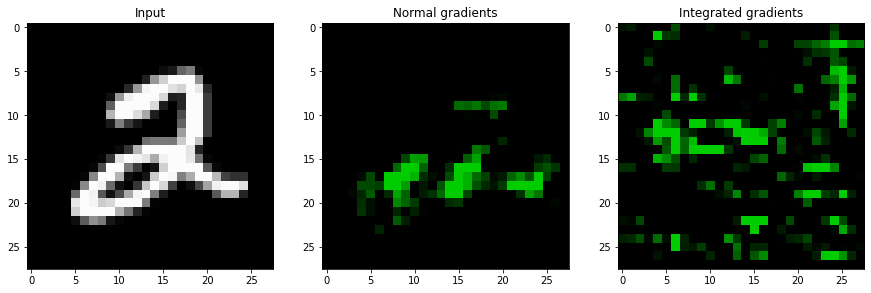

C:\Users\cpt\AppData\Local\Temp/ipykernel_3448/3199753877.py:94: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  connected_components, num_comp = ndimage.measurements.label(


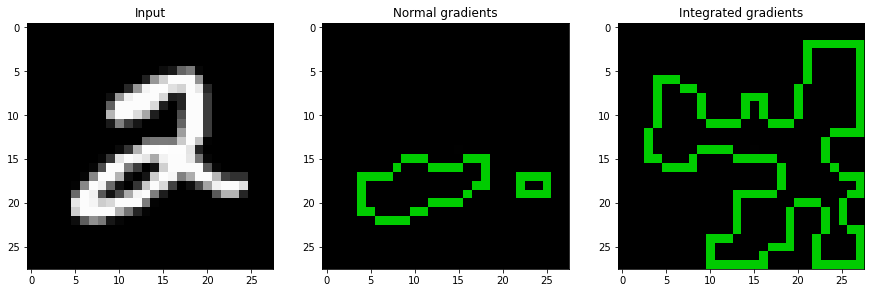

In [15]:

# 6. Get the integrated gradients
igrads = random_baseline_integrated_gradients(
    np.copy(orig_img), top_pred_idx=top_pred_idx, num_steps=100, num_runs=2
)

# 7. Process the gradients and plot
vis = GradVisualizer()
vis.visualize(
    image=orig_img,
    gradients=grads[0].numpy(),
    integrated_gradients=igrads.numpy(),
    clip_above_percentile=70,
    clip_below_percentile=20,
)

vis.visualize(
    image=orig_img,
    gradients=grads[0].numpy(),
    integrated_gradients=igrads.numpy(),
    clip_above_percentile=70,
    clip_below_percentile=20,
    morphological_cleanup=True,
    outlines=True,
)

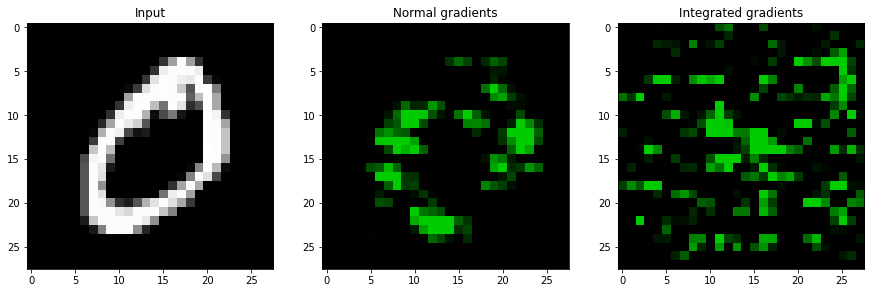

C:\Users\cpt\AppData\Local\Temp/ipykernel_3448/3199753877.py:94: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  connected_components, num_comp = ndimage.measurements.label(


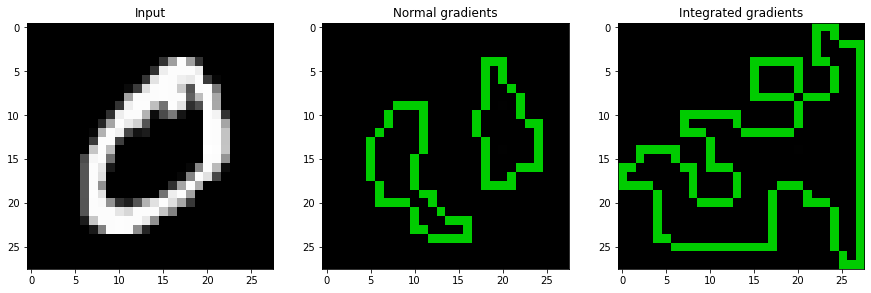

In [16]:

# 6. Get the integrated gradients
igrads_2 = random_baseline_integrated_gradients(
    np.copy(orig_img_2), top_pred_idx=top_pred_idx_2, num_steps=50, num_runs=2
)

# 7. Process the gradients and plot
vis = GradVisualizer()
vis.visualize(
    image=orig_img_2,
    gradients=grads_2[0].numpy(),
    integrated_gradients=igrads_2.numpy(),
    clip_above_percentile=70,
    clip_below_percentile=20,
)

vis.visualize(
    image=orig_img_2,
    gradients=grads_2[0].numpy(),
    integrated_gradients=igrads_2.numpy(),
    clip_above_percentile=99,
    clip_below_percentile=20,
    morphological_cleanup=True,
    outlines=True,
)

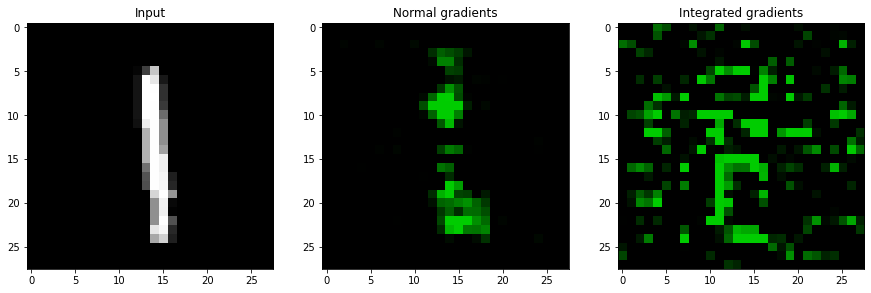

C:\Users\cpt\AppData\Local\Temp/ipykernel_3448/3199753877.py:94: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  connected_components, num_comp = ndimage.measurements.label(


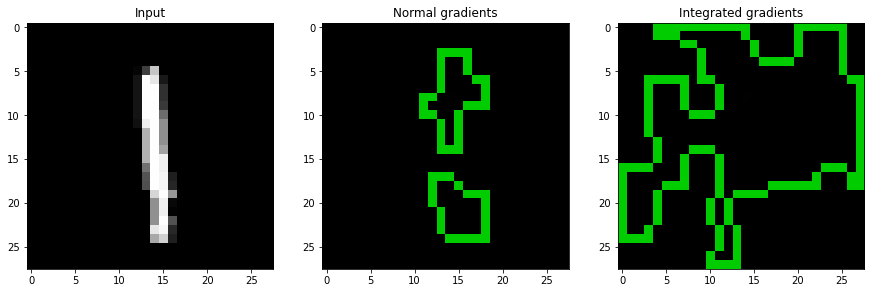

In [17]:
# 6. Get the integrated gradients
igrads = random_baseline_integrated_gradients(
    np.copy(orig_img_3), top_pred_idx=top_pred_idx_3, num_steps=50, num_runs=2
)

# 7. Process the gradients and plot
vis = GradVisualizer()
vis.visualize(
    image=orig_img_3,
    gradients=grads_3[0].numpy(),
    integrated_gradients=igrads.numpy(),
    clip_above_percentile=70,
    clip_below_percentile=20,
)

vis.visualize(
    image=orig_img_3,
    gradients=grads_3[0].numpy(),
    integrated_gradients=igrads.numpy(),
    clip_above_percentile=70,
    clip_below_percentile=20,
    morphological_cleanup=True,
    outlines=True,
)

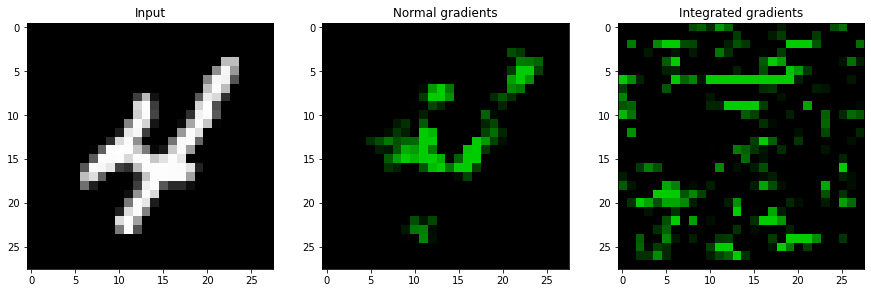

C:\Users\cpt\AppData\Local\Temp/ipykernel_3448/3199753877.py:94: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  connected_components, num_comp = ndimage.measurements.label(


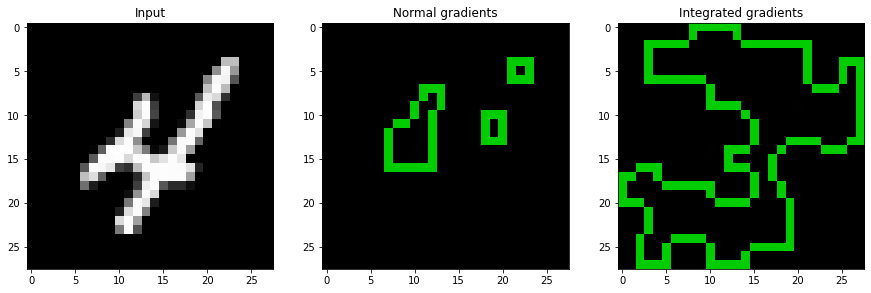

In [18]:
# 6. Get the integrated gradients
igrads = random_baseline_integrated_gradients(
    np.copy(orig_img_4), top_pred_idx=top_pred_idx_4, num_steps=50, num_runs=2
)

# 7. Process the gradients and plot
vis = GradVisualizer()
vis.visualize(
    image=orig_img_4,
    gradients=grads_4[0].numpy(),
    integrated_gradients=igrads.numpy(),
    clip_above_percentile=70,
    clip_below_percentile=20,
)

vis.visualize(
    image=orig_img_4,
    gradients=grads_4[0].numpy(),
    integrated_gradients=igrads.numpy(),
    clip_above_percentile=70,
    clip_below_percentile=20,
    morphological_cleanup=True,
    outlines=True,
)